## Exploratory Data Analysis

Exploratory Data Analysis will be performed on preprocessed data to extract meaningful insights.

Import necessary libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import geopandas as gpd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from joblib import load

pd.set_option("future.no_silent_downcasting", True) # Prevent silent data type changes during operations for future compatibility

In [2]:
# Load cleaned data
df = pd.read_csv("../data/cleaned_data.csv")
display(df.head())

,year,quarter,airport_1,airport_2,distance,daily_passengers,state_1,city_1,state_2,city_2,population_1,density_1,population_2,density_2,lat_1,lon_1,lat_2,lon_2
0,2021,3,ABE,PIE,970,180,PA,Allentown,FL,Tampa,627863.0,2754.2,2861173.0,1320.9,40.602753,-75.469759,37.860600,-78.804199
1,2021,3,ABE,TPA,970,19,PA,Allentown,FL,Tampa,627863.0,2754.2,2861173.0,1320.9,40.602753,-75.469759,37.860600,-78.804199
2,2021,3,ABQ,DAL,580,204,NM,Albuquerque,TX,Dallas,769986.0,1159.8,5830932.0,1478.7,35.084248,-106.649241,40.110860,-77.035636
3,2021,3,ABQ,DFW,580,264,NM,Albuquerque,TX,Dallas,769986.0,1159.8,5830932.0,1478.7,35.084248,-106.649241,40.110860,-77.035636
4,2021,3,ABQ,PHX,328,398,NM,Albuquerque,AZ,Phoenix,769986.0,1159.8,4064275.0,1198.9,35.084248,-106.649241,30.406931,-87.217578


Before performing any data analysis, split the data into accessible and holdout parts to prevent data leakage. Only the training data will be used.

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(df.drop(["daily_passengers"], axis=1), df["daily_passengers"], test_size=0.2, random_state=42)

# Merge the training dataset into a single dataframe
df = pd.concat([X_train, y_train], axis=1)
print("Shape of the training dataset:", df.shape)

Shape of the training dataset: (196762, 18)


Visualize the cities and states that are present in this dataset either as places of origin or destination

<a href="https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html">US Census Bureau</a>

In [4]:
# Load the US states shapefile for mapping state boundaries
gdf_states = gpd.read_file("../data/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
display(gdf_states.head())

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48, -109.04984 31.4995..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.0577 44.99743, -104.05021 44.99..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


Visualize the number of flights and flight routes depending on the origin and destination states and cities

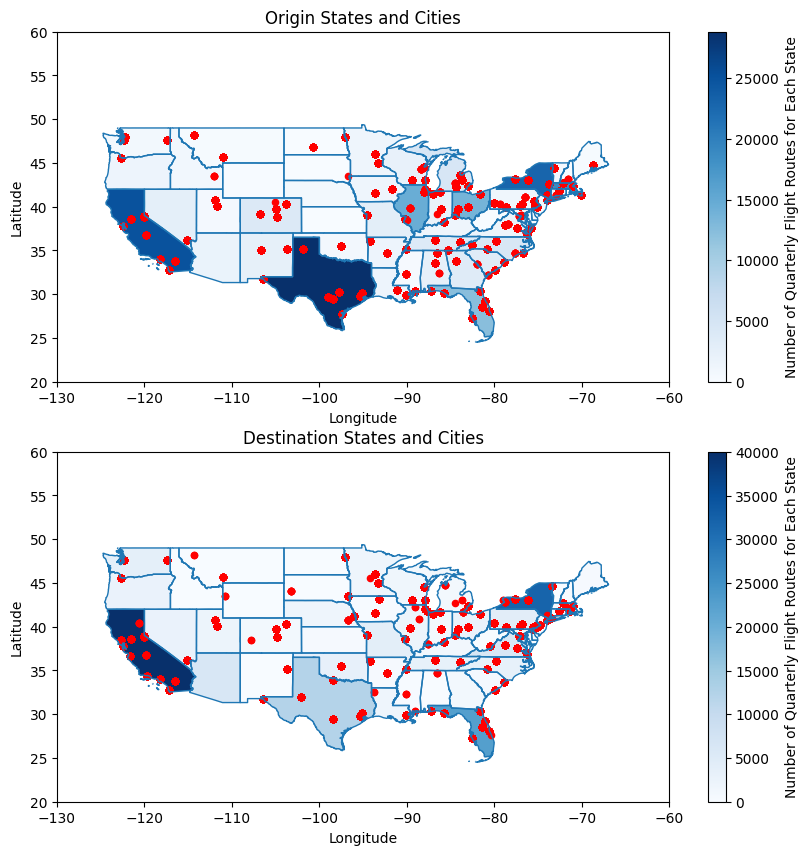

In [5]:
# Calculate flight counts for origin states and destination states, then format as dataframes
state1_counts = df["state_1"].value_counts().rename_axis("state").reset_index(name="count_s1")
state2_counts = df["state_2"].value_counts().rename_axis("state").reset_index(name="count_s2")

# Merge flight counts into gdf_states for origin and destination states data
gdf_states = gdf_states.merge(state1_counts, how="left", left_on="STUSPS", right_on="state")
gdf_states = gdf_states.merge(state2_counts, how="left", left_on="STUSPS", right_on="state")
# Replace missing count values with 0 for states that do not have any flights
gdf_states.fillna({"count_s1": 0, "count_s2": 0}, inplace=True)

# Create geodataframes for origin and destination cities with point geometries from df_train
gdf_cities1 = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_1"], df["lat_1"]))
gdf_cities2 = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_2"], df["lat_2"]))

# Define a function to plot states and cities with flight counts on a map
def plot_map(gdf_states, gdf_cities, counts_col, title, ax):
  # Plot state boundaries
  gdf_states.boundary.plot(ax=ax, linewidth=1)
  # Plot states with color based on flight counts
  gdf_states.plot(column=counts_col, ax=ax, legend=True, legend_kwds={"label": "Number of Quarterly Flight Routes for Each State"}, cmap="Blues")
  gdf_cities.plot(ax=ax, markersize=20, color="red", label="Cities", legend=True)
  ax.set(title=title, xlabel="Longitude", ylabel="Latitude", xlim=(-130, -60), ylim=(20, 60))

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_map(gdf_states, gdf_cities1, "count_s1", "Origin States and Cities", ax[0])
plot_map(gdf_states, gdf_cities2, "count_s2", "Destination States and Cities", ax[1])
plt.show()

The two maps above show that California, Texas and New York are the major states that account for most flight routes. An interesting point to be noted is that while Texas does have a lot of flights going out of the state, there are not as many flights that come into it.

Visualize the trend of the demand over time

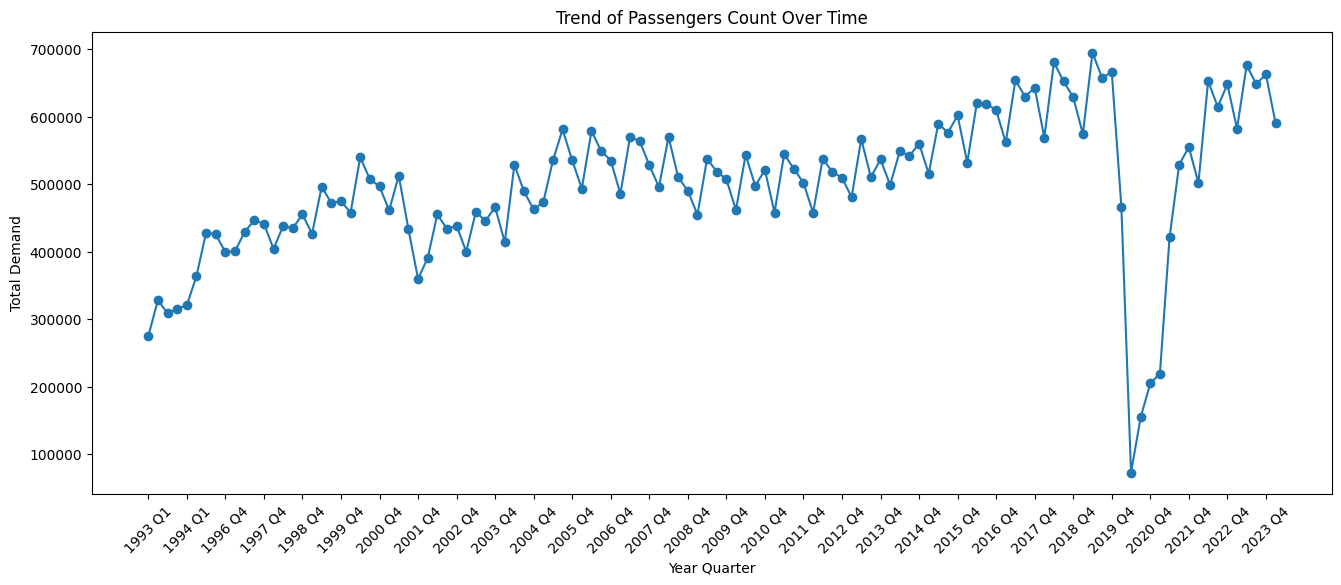

In [6]:
df["year_quarter"] = df["year"].astype(str) + " Q" + df["quarter"].astype(str)
# df_train_encoded["year_quarter"] = pd.to_datetime(df_train_encoded["year_quarter"], format="%YQ%q")
demand_trend = df.groupby("year_quarter")["daily_passengers"].sum().reset_index()

# Plot the demand trend over time
plt.figure(figsize=(16, 6))
plt.plot(demand_trend["year_quarter"], demand_trend["daily_passengers"], marker="o")
plt.xlabel("Year Quarter")
plt.ylabel("Total Demand")
plt.xticks(ticks=range(0, len(demand_trend), 4), rotation=45)
plt.title("Trend of Passengers Count Over Time");

# Remove the column after visualization
df.drop("year_quarter", axis=1, inplace=True)

After converting all feature variables to have numerical values, we can try visualizing a correlation matrix. As there might be nonlinear relationships between variables, this matrix will simply be used as a reference rather than an absolute criterion to judge whether certain features should be included or not.

In [7]:
X_train.head()

,year,quarter,airport_1,airport_2,distance,state_1,city_1,state_2,city_2,population_1,density_1,population_2,density_2,lat_1,lon_1,lat_2,lon_2
147546,2009,4,ORD,RIC,642,IL,Chicago,VA,Richmond,8497759.0,4614.5,1073223.0,1463.7,41.775002,-87.696388,37.540759,-77.433932
12123,2006,3,DAL,PDX,1626,TX,Dallas,OR,Portland,5830932.0,1478.7,2095808.0,1868.8,40.110860,-77.035636,45.516018,-122.681425
167944,1993,3,ABQ,DCA,1670,NM,Albuquerque,DC,Washington,769986.0,1159.8,5116378.0,4235.7,35.084248,-106.649241,38.892062,-77.019912
71631,1996,3,BOS,IAH,1609,MA,Boston,TX,Houston,4328315.0,5319.0,5970127.0,1384.0,42.358894,-71.056742,29.760803,-95.369506
66928,1999,3,DAL,JAN,408,TX,Dallas,MS,Jackson,5830932.0,1478.7,335171.0,529.9,40.110860,-77.035636,30.325968,-81.656760


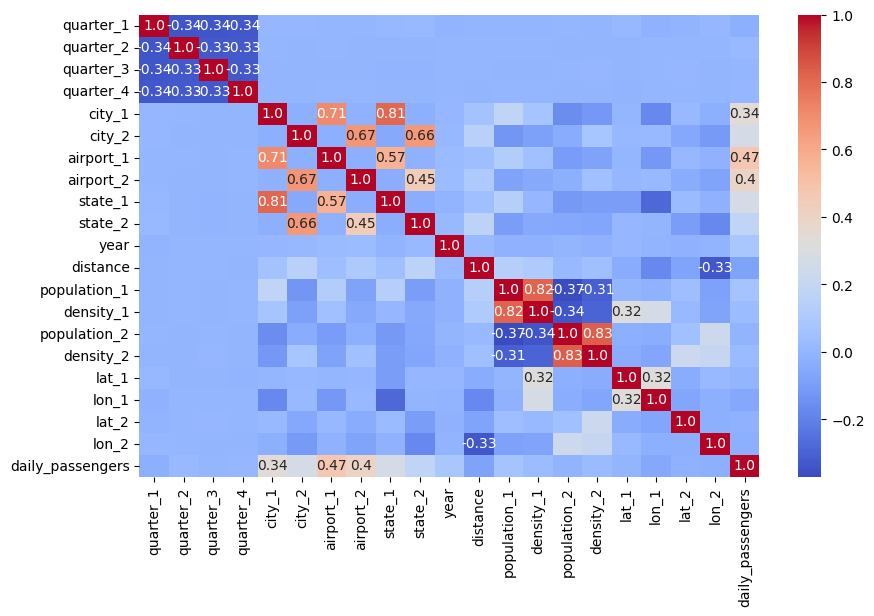

In [11]:
# Load the pipeline and feature names to transform the data
preprocessing_pipeline = load("../models/preprocessing_pipeline.joblib")
feature_names = load("../models/feature_names.joblib")

# Transform the data
X_train_transformed = preprocessing_pipeline.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names, index=X_train.index)
df_transformed = pd.concat([X_train_transformed, y_train], axis=1)

# Calculate the correlation matrix
corr_matrix = df_transformed.corr()

# Set the threshold for showing annotations
threshold = 0.3

# Create a custom annotation matrix where only correlations above the threshold are shown
annot = corr_matrix.where(corr_matrix.abs() >= threshold).round(2).astype(str)
annot = annot.where(corr_matrix.abs() >= threshold, "")  # Empty string for values below the threshold

# Plot the heatmap with the custom annotation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=annot, fmt="", cmap="coolwarm");